# Notebooks

## General setup

We first setup the notebook for plotting inline, in svg format, and indented pretty print.

In [1]:
import matplotlib.pyplot as P
import numpy as N
from IPython.display import set_matplotlib_formats, Code
import pprint
pp = pprint.PrettyPrinter(indent=4, compact = True)

%matplotlib inline
set_matplotlib_formats('svg')


We then tune the figure parameters

In [2]:
P.rcParams["figure.figsize"] = (12, 9)
P.rcParams['image.cmap'] = "seismic" # palette for good contrast
P.rc("font", size=16)

We also tune the display of pandas dataframes:

In [3]:
import pandas as pd
pd.options.display.max_columns = 8


At last, the ResultReader from metadynamic package is loaded

In [4]:
from metadynamic import ResultReader, __version__
print(f"Data read with metadynamic version: {__version__}")


Data read with metadynamic version: 1.0.3


## Simple system

This is a simple run, for a minimalist system with a minimal set of possible reactions:

- ABC → A + BC
- ABC → AB + C
- AB → A + B
- BC → B + C

These reactions are implicitely built from an `hydrolysis` rule, with the introduction of the `ABC` compound at the initial state.

### Code

A `json` file describes the run parameters:

In [5]:
Code(filename="simple.json")

{
    "name" : "Simple",
    "savedir" : "",
    "logdir" : "runlog",
    "init" :
    {
	"abc": 1000
    },
    "conc" : 1.0,
    "tend" : 10.0,
    "tstep" : 0.1,
    "save" : ["a", "b", "c", "abc", "ab", "bc"],
    "stat" : "simple-stat.json",
    "rulemodel" : "simple.py",
    "reactions" : "H",
   "parameters" :{
	"khyd_head" : 1.0,
	"khyd_queue" : 0.5
    }
}

Collected statistics are define in `simple-stat.json`:

In [6]:
Code(filename="simple-stat.json")

{
    "nbcomp":
    {
	"method" : "+"
    },
    "poolsize":
    {
	"method" : "+",
	"full" : true
    },
    "nbreac":
    {
	"method" : "+",
	"collection" : "reactions"
    },
    "poolreac":
    {
	"method" : "+",
	"collection" : "reactions",
	"full" : true
    },
    "mix_entro":
    {
	"prop" : "entropy",
	"method" : "m"
    }
}

The rules describing the hydrolysis reaction rule are described as a python module:

- a Categorizer function classify compounds with alphabetic names as `polym`;
- a Propertizer function computes the property `length` of compounds;
- a ProdBuilder function defines how a compound can be `cut`, e.g. `cut(["abcdef"], 3)` returns `("abc", "def")`;
- a Constbuilder function set kinetic constants to `khyd_head` for reaction with `variant=1` (i.e. if the hydrolysis only cuts the first monomer), and to `khyd_queue` in other cases;
- a VariantBuilder function gives all the possible reaction variants that can be obtained for the hydrolysis of a given compound (e.g. for the hydrolysis of "`ABCD"`, the possible variants are `[1,2,3]`;
- the set of rules is finally obtained by assembling these elements in a `default_ruleset` dictionary.


In [7]:
Code(filename="simple.py")

from typing import Dict, Any

from metadynamic.ruleset import (
    Categorizer,
    Propertizer,
    ProdBuilder,
    ConstBuilder,
    VariantBuilder,
    kalternate,
    rangevariant,
)


# Categorizer

# A polymer is a chain of characters, e.g. abc
polym: Categorizer = lambda name: name.isalpha()

# Propertizer
length: Propertizer = lambda name: len(name)

# ProdBuilder

# e.g. abcdef -[3]-> abc + def
cut: ProdBuilder = lambda names, variant: (names[0][:variant], names[0][variant:])

# ConstBuilder

khyd: ConstBuilder = kalternate(
    condition=lambda names, variant: variant == 1,
    name_t="khyd_head",
    name_f="khyd_queue",
)

# (length-1) possible reactions from a given reaction
# (e.g. abc -[1]-> a+bc and abc -[2]->  ab+c)
intervariant: VariantBuilder = rangevariant(reacnum=0, first_offset=1)

# Default Ruleset

default_ruleset: Dict[str, Any] = {
    "categories": ["polym"],
    "properties": ["length"],
    "rules": {
        "H": {
            "reactants": ["polym"],
            "builder_func": "cut",
            "builder_const": "khyd",
            "builder_variant": "intervariant",
            "descr": "Hydrolysis",
        },
    },
}

### Results

A run was launched by `mpirun -np 40 metarun -c "Simple polymer hydrolysis" simple.json`.
All results were recorded in a single `hdf5` file:

In [8]:
res = ResultReader("simple.hdf5")
end = res.params.attrs["tend"]
print(res.printinfo)

----------------
Simple polymer hydrolysis
----------------
metadynamic version 1.0.3, ran on 40 threads on Lady3Jane
from [17.06.2020-15:57:24] to 15:57:31, 17/06/20
results saved in 'simple.hdf5'
----------------
#0: ending n°11 at runtime t=5.2935051918029785s; No more reactions can be processed -> after processing bc->b+c
#1: ending n°11 at runtime t=4.005395412445068s; No more reactions can be processed -> after processing ab->a+b
#2: ending n°11 at runtime t=4.974959373474121s; No more reactions can be processed -> after processing bc->b+c
#3: ending n°11 at runtime t=5.369208335876465s; No more reactions can be processed -> after processing bc->b+c
#4: ending n°11 at runtime t=6.093284606933594s; No more reactions can be processed -> after processing bc->b+c
#5: ending n°11 at runtime t=4.290343284606934s; No more reactions can be processed -> after processing ab->a+b
#6: ending n°11 at runtime t=5.174767971038818s; No more reactions can be processed -> after processing bc->b+c


Full data table (averaged values over each run):

In [9]:
res.table()

,0,1,2,3,...,91,92,93,94
thread,19.500000,19.500000,19.500000,19.500000,...,19.000000,27.000000,27.000000,27.000000
ptime,0.020072,0.080187,0.138607,0.197621,...,6.191926,6.246955,6.284940,6.322628
memuse,156.294922,156.396194,156.440826,156.440826,...,157.351562,157.496094,157.496094,157.496094
step,0.000000,1.000000,2.000000,3.000000,...,91.000000,92.000000,93.000000,94.000000
dstep,0.000000,149.949997,289.649994,419.549988,...,1999.000000,1999.000000,1999.000000,1999.000000
time,0.000000,0.100574,0.200950,0.300885,...,9.295250,9.437451,9.437451,9.437451
a,0.000000,0.032592,0.061433,0.087317,...,0.333167,0.333333,0.333333,0.333333
b,0.000000,0.002433,0.008533,0.017675,...,0.333000,0.333000,0.333000,0.333000
c,0.000000,0.017392,0.035117,0.052533,...,0.333167,0.333000,0.333000,0.333000
abc,0.333333,0.285783,0.245317,0.211158,...,0.000000,0.000000,0.000000,0.000000


The concentration of each compound can be plotted (thick line for the average over all runs, thin line for each run)

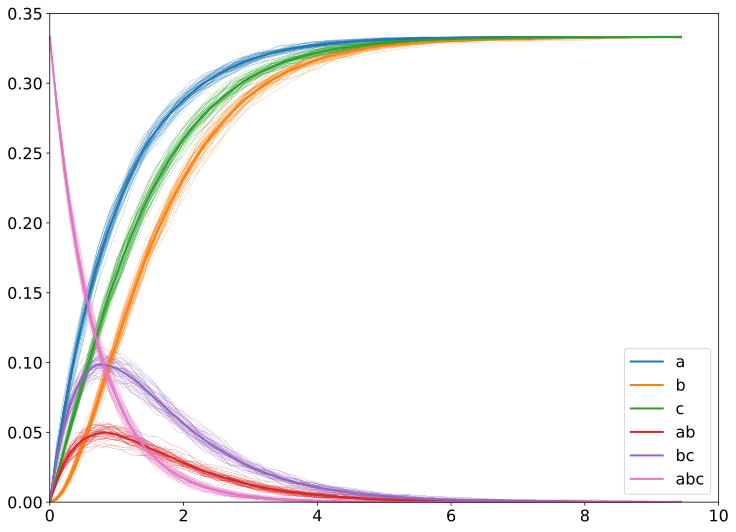

In [10]:
names = ["a", "b", "c", "ab", "bc", "abc"]
colors = ["blue", "orange", "green", "red", "purple", "pink"]

for name, color in zip(names, colors):
    P.plot(*res.x_y_proc(name), linewidth=0.2, color=f"tab:{color}")

for name, color in zip(names, colors):
    P.plot(*res.x_y(name), linewidth=2, color=f"tab:{color}", label=name)
    


P.legend()
P.xlim(0,end)
P.ylim(0);

## APED system

This is a complete example, 

### Code

Simulation ruleset code.

- Categorizer functions are defined for being able to categorize a compound from its name (for example `polymer("AbCD")` returns `True`, thus a compound with name `"AbCD"` will be categorized as a `polymer`)
- Propertizer functions are defined for computing a compound property from its name (for example `length("AbCD*")` returns `4`, thus the compound of name `"AbCD*"` posesses a `length` of value `4`)
- ProdBuilder functions are defined for computing a list of names of product compounds, from a list of names of reactant compounds and a reaction variant number (for example `cut(names=["ABCD"], variant=1)` will return `["A", "BCD"]`; it will be used for processing the hydrolysis reaction `ABCD → A + BCD`
- ConstBuilder functions are defined for computing a kinetic constant from ...
...
- The Ruleset is defined by assembling all theses previously defined elements, for creating all the rules necessary for defining all possible chemical reactions.


In [11]:
Code(filename="aped.py")

"""APED model definition module

This system is defined by:
 - Activation reaction; e.g.  A -> A*
 - Activated polymerisation reaction; e.g.  A* + BcD -> ABcD
 - Epimerization reaction; e.g.  ABcD -> aBcD
 - Depolymerization reaction; e.g.  aBcD -> aBc + D
"""

from typing import Dict, Any

from metadynamic.ruleset import (
    Categorizer,
    Propertizer,
    ProdBuilder,
    ConstBuilder,
    VariantBuilder,
    Compset,
    kalternate,
    kdualchoice,
    novariant_gen,
    singlevariant,
    rangevariant,
)

# Definition of Categorizer and Propertizer functions

polym: Categorizer = lambda name: name.isalpha()
"""Definition of a polymer

Return True if the name is an alphabetic string:
>>> polym("AaDcs")
True
>>> polym("A2")
False
"""

mono: Categorizer = lambda name: polym(name) and len(name) == 1
"""Definition of a monomer

Return True if the name is polymer of length one:
>>> mono("Abc")
False
>>> mono("b")
True
"""

actpol: Categorizer = lambda name: name[-1] == "*" and name[:-1].isalpha()
"""Definition of an activated polymer

Return True if the name is an alphabetic string + a '*' char at its end:
>>> actpol("AbcD")
False
>>> actpol("Abcd*")
True
"""


actmono: Categorizer = lambda name: actpol(name) and len(name) == 2
"""Definition of an activated monomer

Return True is the name is an activated polymer of length 2:
>>> actmono("Abcd*")
False
>>> actmono("A*")
True
"""

longpol: Categorizer = lambda name: polym(name) and len(name) > 1
"""Definition of a long polymer

Return True if the name is a polymer of length 2 or more:
>>> longpol("A")
False
>>> longpol("Abcd")
True
"""


length: Propertizer = lambda name: (
    1
    if mono(name)
    else len(name)
    if polym(name)
    else len(name) - 1
    if actpol(name)
    else 0
)
"""Definition of length property

Return the length of a monomer, polymer or activated polymer:
>>> length('A')
1
>>> length('AbCD')
4
>>> length('Ab*')
3
>>> length('A2')
0
"""


def asym(name: str) -> int:  # Propertizer
    """Definition of asymmetry property

    Each upper char in the name is counted as +1, each lower char as -1:
    >>> asym('AAAa')
    2
    >>> asym('AAAA')
    4
    >>>> asym('aaaa')
    -4
    >>>> asym('aAAa')
    0
    """
    res = 0
    for char in name:
        if char.isupper():
            res += 1
        elif char.islower():
            res -= 1
    return res


right: Categorizer = lambda name: asym(name) > 0
"""Definition of right category

Return True if the name has a positive asymmetry property.
"""

left: Categorizer = lambda name: asym(name) < 0
"""Definition of left category

Return True if the name has a negative asymmetry property.
"""


# Definition of ProdBuilder functions

cut: ProdBuilder = lambda names, variant: (names[0][:variant], names[0][variant:])
act_polym: ProdBuilder = lambda names, variant: (names[0][:-1] + names[1],)
activ: ProdBuilder = lambda names, variant: (names[0] + "*",)
epimer: ProdBuilder = lambda names, variant: (
    names[0][:variant] + names[0][variant].swapcase() + names[0][variant + 1 :],
)


# ConstBuilder


def samecase(one: str, two: str) -> bool:
    return (one.islower() and two.islower()) or (one.isupper() and two.isupper())


def samebefore(names: Compset, variant: int) -> bool:
    name = names[0]
    return variant < (length(name) - 1) and samecase(name[variant], name[variant + 1])


def sameafter(names: Compset, variant: int) -> bool:
    name = names[0]
    return (variant > 0) and samecase(name[variant], name[variant - 1])


kpola: ConstBuilder = kalternate(
    condition=lambda names, variant: samecase(names[0][-2], names[1][0]),
    name_t="kpola_same",
    name_f="kpola_diff",
)

kact: ConstBuilder = kalternate(
    condition=lambda names, variant: length(names[0]) == 1,
    name_t="kact_mono",
    name_f="kact_pol",
)

khyd: ConstBuilder = kalternate(
    condition=lambda names, variant: samecase(names[0][variant - 1], names[0][variant]),
    name_t="khyd_same",
    name_f="khyd_diff",
)

kepi: Cons

Simulation parameters:

In [12]:
Code(filename="aped.json")

{
    "name" : "APED",
    "savedir" : "",
    "logdir" : "testlog",
    "init" :
    {
	"a": 10000,
	"A": 10000
    },
    "conc" : 3.0,
    "tend" : 1000.0,
    "tstep" : 5.0,
    "sstep" : 50.0,
    "save" : ["a", "aa", "aaa", "aaaa", "A", "Aa", "aA", "AA", "a*", "A*"],
    "stat" : "aped-stat.json",
    "maps" : "aped-maps.json",
    "rtlim" : 6000.0,
    "rulemodel" : "aped.py",
    "reactions" : ["A", "H", "E", "a"],
    "parameters" :{
	"kpola_same": 1.0,
	"kpola_diff": 0.1,
	"khyd_same": 1.0,
	"kepi_diff": 1.0,
	"kact_mono": 1.0
    },
    "dropmode" : "drop",
    "maxsteps" : 100000,
    "maxlog" : 1000
}

In [13]:
Code(filename="aped-stat.json")

{
    "nbcomp":
    {
	"method" : "+"
    },
    "poolsize":
    {
	"method" : "+",
	"full" : true
    },
    "nbreac":
    {
	"method" : "+",
	"collection" : "reactions"
    },
    "poolreac":
    {
	"method" : "+",
	"collection" : "reactions",
	"full" : true
    },
    "len_mean":
    {
	"prop" : "length"
    },
    "len_min":
    {
	"prop" : "length",
	"method" : "min"
    },
    "len_max":
    {
	"prop" : "length",
	"method" : "max"
    },
    "len_max_pool":
    {
	"prop" : "length",
	"method" : "max",
	"full" : true
    },
    "wlen_mean":
    {
	"prop" : "length",
	"weight" : "pop",
	"method" : "m"
    },
    "slen_mean":
    {
	"prop" : "length",
	"weight" : "single",
	"method" : "m"
    },
    "slen_sum":
    {
	"prop" : "length",
	"weight" : "single",
	"method" : "+"
    },
    "tot_m":
    {
	"prop" : "length",
	"weight" : "pop",
	"method" : "+"
    },
    "tot_c":
    {
	"prop" : "pop",
	"weight" : "count",
	"method" : "+"
    },
    "asym":
    {
	"prop" : "asym",
	"weight" : "pop",
	"method" : "+"
    },
    "mix_entro":
    {
	"prop" : "entropy",
	"method" : "m"
    },
    "reac_entro":
    {
	"prop" : "entropy",
	"method" : "m",
	"collection" : "reactions"
    },
    "nbact":
    {
	"prop" : "actpol",
	"weight": "pop",
	"method" : "+"
    }
}

In [14]:
Code(filename="aped-maps.json")

{
    "lendist":
    {
	"prop" : "pop",
	"sort" : "length"
    },
    "pooldist":
    {
	"prop" : "pop",
	"sort" : "length",
	"full" : true
    },
    "wlendist":
    {
	"prop" : "pop",
	"weight" : "length",
	"sort" : "length"
    },
    "slendist":
    {
	"prop" : "pop",
	"weight" : "single",
	"sort" : "length"
    },
    "asymdist":
    {
	"prop" : "asym",
	"weight" : "pop",
	"method" : "+",
	"sort" : "length"
    },
    "s_asymdist":
    {
	"prop" : "asym",
	"weight" : "single",
	"method" : "+",
	"sort" : "length"
    }
}

### Load result

Results from a simulation are loaded

In [15]:
res = ResultReader("aped.hdf5")

Informations from the run can be printed

In [16]:
nbthread = res.size
end = res.params.attrs["tend"]
print(res.printinfo)

----------------
APED model simulation
----------------
metadynamic version 1.0.3, ran on 40 threads on Lady3Jane
from [17.06.2020-16:01:39] to 16:16:04, 17/06/20
results saved in 'aped.hdf5'
----------------
#0: ending n°10 at runtime t=825.3445434570312s; Time is up -> t=1000.000056418917
#1: ending n°10 at runtime t=843.4241333007812s; Time is up -> t=1000.0000032501846
#2: ending n°10 at runtime t=816.7442626953125s; Time is up -> t=1000.0000027095062
#3: ending n°10 at runtime t=795.2409057617188s; Time is up -> t=1000.0000289125553
#4: ending n°10 at runtime t=836.850341796875s; Time is up -> t=1000.0000496402653
#5: ending n°10 at runtime t=825.904296875s; Time is up -> t=1000.0002079251959
#6: ending n°10 at runtime t=805.1301879882812s; Time is up -> t=1000.0000101812566
#7: ending n°10 at runtime t=841.98046875s; Time is up -> t=1000.0000550657451
#8: ending n°10 at runtime t=794.9343872070312s; Time is up -> t=1000.0001191530737
#9: ending n°10 at runtime t=843.3556518554688

### Data tables

A data summary can be obtained:

In [17]:
res.table()

,0,1,2,3,...,197,198,199,200
thread,19.500000,19.500000,19.500000,19.500000,...,1.950000e+01,1.950000e+01,1.950000e+01,1.950000e+01
ptime,0.040992,6.292937,13.112409,19.936161,...,8.113497e+02,8.152224e+02,8.192756e+02,8.231605e+02
memuse,157.107712,157.393646,157.441696,157.482712,...,1.582021e+02,1.582227e+02,1.582515e+02,1.583387e+02
step,0.000000,1.000000,2.000000,3.000000,...,1.970000e+02,1.980000e+02,1.990000e+02,2.000000e+02
dstep,0.000000,74374.171875,143630.968750,212812.125000,...,1.674451e+07,1.683224e+07,1.691995e+07,1.700760e+07
time,0.000000,5.000081,10.000088,15.000064,...,9.850001e+02,9.900000e+02,9.950001e+02,1.000000e+03
a,1.500000,0.333206,0.336675,0.335438,...,4.181287e-01,4.149787e-01,4.151288e-01,4.159650e-01
aa,0.000000,0.194437,0.192904,0.193826,...,2.468213e-01,2.487825e-01,2.483588e-01,2.473162e-01
aaa,0.000000,0.045735,0.044880,0.045038,...,6.468751e-02,6.361874e-02,6.474750e-02,6.510375e-02
aaaa,0.000000,0.007174,0.007001,0.006581,...,1.089750e-02,1.115625e-02,1.092000e-02,1.074750e-02


## Chemical reaction networks

We can check the CRN before bifurcation...

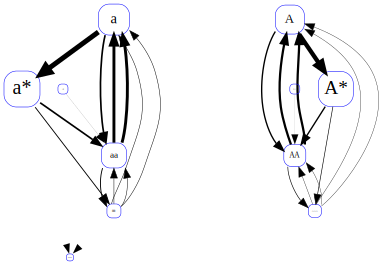

In [18]:
res.getsnap(3,0)

... and after bifurcation

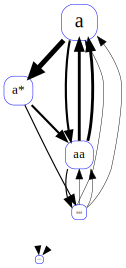

In [19]:
res.getsnap(3,-1)

### Results: plotting

We can plot time evolution of compounds (per thread and average behavior)

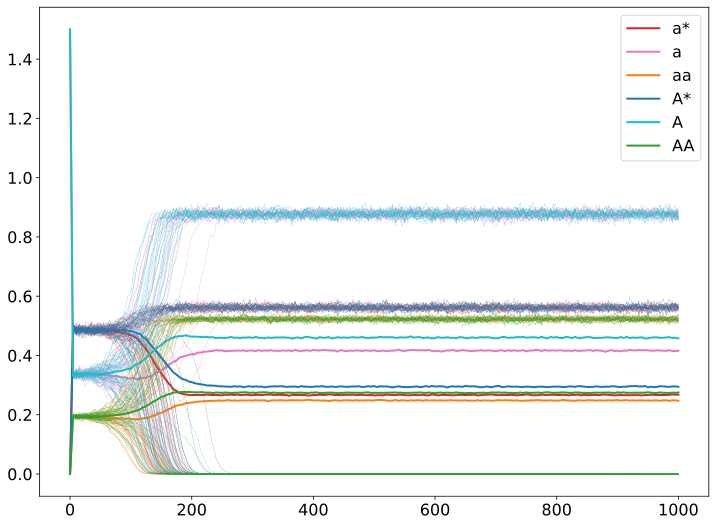

In [20]:
complist = ["a*", "a", "aa", "A*", "A", "AA"]
colorlist = ["tab:red", "tab:pink", "tab:orange", "tab:blue", "tab:cyan", "tab:green"]

for name, color in zip(complist, colorlist):
    P.plot(*res.x_y_proc(name), linewidth=0.2, color=color)
    P.plot(*res.x_y(name, method="p1"), linewidth=0.2, color=color)    
    P.plot(*res.x_y(name), linewidth=2, color=color, label=name)
    

P.legend()



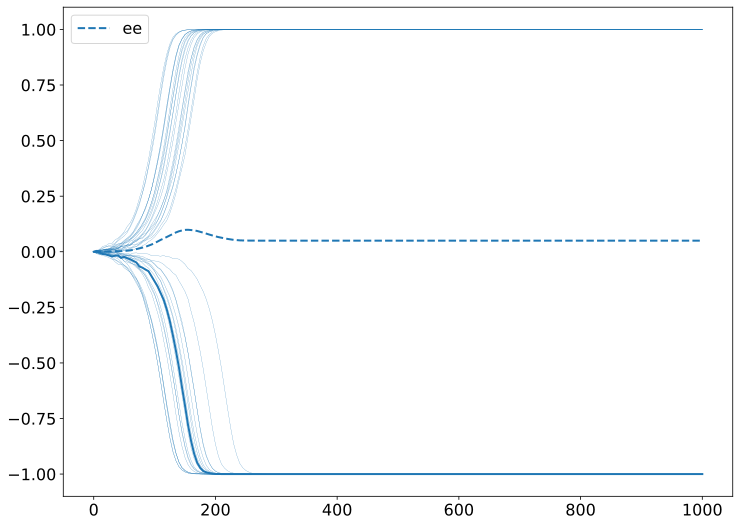

In [21]:
for i in range(nbthread):
    P.plot(res.get("time", method=f"p{i}"), res.get("asym", method=f"p{i}")/res.get("tot_m", method=f"p{i}"), linewidth=0.2, color="tab:blue", label="")
P.plot(res.get("time", method=f"p{i}"), res.get("asym", method=f"p{i}")/res.get("tot_m", method=f"p{i}"), linewidth=2, color="tab:blue", label="")
P.plot(res.get("time", method="m"), res.get("asym", method="m")/res.get("tot_m", method="m"), "--", linewidth=2, color="tab:blue", label="ee")

P.legend()

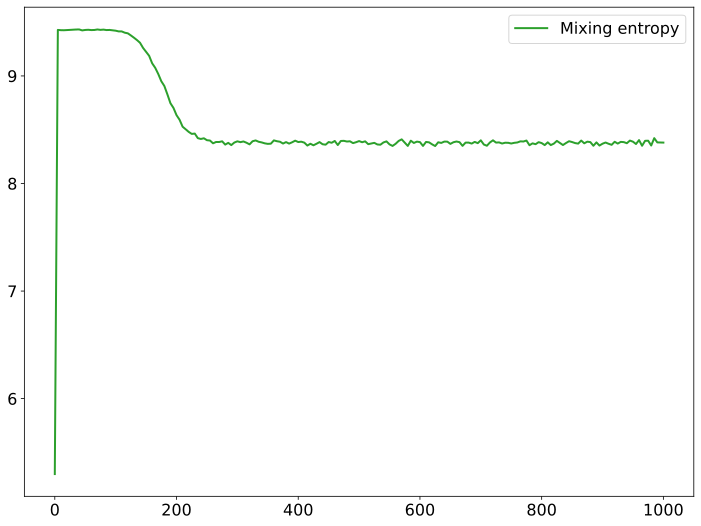

In [22]:
P.plot(res["time"], N.log(res["tot_c"])-res["mix_entro"]/res["tot_c"], linewidth=2, color="tab:green", label="Mixing entropy")

P.legend();
